<a href="https://colab.research.google.com/github/djonpietro/AP-MAQ-UFRJ/blob/main/projeto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizagem de Máquina I

## Hugo Tremonte de Carvalho

#### hugo@dme.ufrj.br

* NOME: João Pedro Silva de Sousa
* DRE: 122122366
* E-MAIL CADASTRADO NO CLASSROOM: joaopss@dcc.ufrj.br

Este _notebook_ é correspondente ao nosso primeiro projeto, passado no dia 18/09/2025 e para entrega no dia 05/10/2024. Ele consiste em resolver um problema prático. A entrega da atividade deve ser feita através do Google Classroom, fazendo um _upload_ deste _notebook_, devidamente atualizado com as suas resoluções e implementações. Recomendo fortemente que façam o trabalho no Google Colab, pois assim temos certa garantia de estarmos rodando tudo no mesmo ambiente e que eu conseguir executar o código de vocês sem dificuldades.

O projeto é **individual**.

O objetivo do projeto é analisar uma base de dados contendo informações sobre corridas de Uber, e tentar prever o valor da corrida com base em atributos de interesse. A base de dados encontra-se disponível [aqui](https://www.kaggle.com/datasets/yasserh/uber-fares-dataset).

O arquivo `.csv` tem poucas colunas: `fare_amount` é a coluna que desejamos prever, e temos também as colunas abaixo para usar como preditoras:
* `key` - _a unique identifier for each trip_
* `pickup_datetime` - _date and time when the meter was engaged_
* `passenger_count` - _the number of passengers in the vehicle (driver entered value)_
* `pickup_longitude` - _the longitude where the meter was engaged_
* `pickup_latitude` - _the latitude where the meter was engaged_
* `dropoff_longitude` - _the longitude where the meter was disengaged_
* `dropoff_latitude` - _the latitude where the meter was disengaged_

Note que a coluna `key` não será um preditor, já que contém somente uma variável de identificação da corrida. Porém, para que as outras colunas sejam propriamente utilizadas como preditoras, talvez seja necessário algum pré-processamento:
* Precisaremos converter as informações de latitude e longitude em distância ou nossos algoritmos serão capazes de fazê-lo "automaticamente"? Mesmo caso o façam, ter a distância logo de cara auxilia no processo de previsão?
* A coluna `pickup_datetime` tem muita informação útil, e pode ser convertida em muitas outras informações para te auxiliar na predição, por exemplo: dia da semana da corrida, se é feriado ou não, etc... porém, essas informações não são imediatas e vão requerer um certo "trabalho sujo" da sua parte, bem como um tico de ferramentas de processamento de texto :-)
* Note que, ao converter `pickup_datetime` para, digamos, dia da semana, será necessário converter essa informação em algo numérico. Aplicar `One Hot Encoding` é uma boa opção? Estude isso com carinho.
* Note que algumas variáveis podem ter alguns valores esquisitos: procure cuidadosamente por dados faltantes e/ou valores irreais (p. ex., corridas com 10 passageiros ou começando no Pólo Norte)

Alguns pontos que o seu trabalho deve conter:
* Análise exploratória bem aprofundada e interpretada: os nossos dados são muito interpretáveis! Além de fazer o que já esperamos (estudar correlações, visualizar histogramas, etc.), sua análise exploratória deve ser esclarecedora sobre distância entre ponto de partida e ponto de chegada, distribuição das corridas ao longo dos dias da semana, distribuição das corridas ao longo dos meses, estudar como (potencialmente) os atributos se relacionam com a resposta (sem e com pré-processamento), analisar (possível) influência do número de passageiros no preço da corrida, etc... Portanto, não basta fazer meia dúzia de gráficos para "cumprir tabela"! A análise exploratória deve informar muito sobre a base de dados e guiar os próximos passos!
* Descrição da caiação de novos atributos a partir das colunas já presentes na base, caso você o faça
* Treinamento e validação de todos os modelos de regressão que vimos até o momento, juntamente com uma interpretação de seus resultados
* Em particular, os coeficientes das regressões paramétricas devem ser interpretados, bem como a `feature_importance_` dos modelos baseados em árvores
* Decisão de um "melhor" modelo para realizar previsões, com justificativa

Tome cuidado que a base é grande: poucos atributos porém muitas linhas! É bem provável que você precise tomar cuidado ao usar métodos pesados como `GridSearchCV`, ou até mesmo nos métodos `.fit()` dos nossos estimadores. Usar as coisas ingenuamente pode ser computacionalmente inviável. Seja sagaz em suas escolhas!

In [ ]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import holidays

from folium.plugins import HeatMap
from scipy import stats

from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error as MSE


from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# Tratando os Dados

Essa seção consitirá de um pré-processamento dos dados
para facilitar a análise exploratória.

In [ ]:
# Carregando os dados para análise
DATA_FILE_PATH = "uber.csv"
df = pd.read_csv(DATA_FILE_PATH, sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


Um registro tem coordenadas do desembarque nulos. Como trata-se apenas
de um registro, irei eliminá-lo. Além disso, vamos logo calcular as
distâncias para facilitar interpretação e extrair informações das datas.

In [ ]:
# Essa função foi gerada por um LLM
def haversine_km(lat1, lon1, lat2, lon2):
    """
    Rotina para computar distância sob a hipótese de que
    a Terra é uma esfera
    """
    # entradas em graus; saída em metros
    R = 6371000.0  # raio médio da Terra em metros
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c / 1000

df['distance_km'] = haversine_km(
    df['pickup_latitude'].values,
    df['pickup_longitude'].values,
    df['dropoff_latitude'].values,
    df['dropoff_longitude'].values,
)

# Extraindo informações das datas
df['pickup_dt'] = pd.to_datetime(df['pickup_datetime'], utc=True)
df['day'] = df['pickup_dt'].apply(lambda x: x.day)
df['month'] = df['pickup_dt'].apply(lambda x: x.month)
df['year'] = df['pickup_dt'].apply(lambda x: x.year)
df['weekday'] = df['pickup_dt'].apply(lambda x: x.weekday())
df['hour'] = df['pickup_dt'].apply(lambda x: x.hour)

# Determinando se o dia da corrid é útil ou não
us_holidays = holidays.CountryHoliday(country='US')
df['feriado'] = df['pickup_dt'].apply(lambda x: int(x.date() in us_holidays))
df['dia_util'] = (
    (~df['feriado']) &
    (~df['weekday'].isin([5, 6]))
).astype(dtype=int)
# Eliminando registros com campos nulos
data = df.dropna(axis=0).drop(columns=['key', 'Unnamed: 0', 'pickup_datetime'])

# Obter estatísticas rapídas sobre os dados
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,day,month,year,weekday,hour,feriado,dia_util
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543,20.855350,15.704739,6.281791,2011.742434,3.048435,13.491387,0.022620,0.695668
std,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995,382.964642,8.687377,3.438933,1.856400,1.946946,6.515505,0.148689,0.460125
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,0.000000,1.000000,1.000000,2009.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000,1.215222,8.000000,3.000000,2010.000000,1.000000,9.000000,0.000000,0.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000,2.120992,16.000000,6.000000,2012.000000,3.000000,14.000000,0.000000,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000,3.875169,23.000000,9.000000,2013.000000,5.000000,19.000000,0.000000,1.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000,16409.239135,31.000000,12.000000,2015.000000,6.000000,23.000000,1.000000,1.000000


Numa primeira análise, temos que


- `fare_amount`: boa parte das corridas custaram menos de 13 dólares. Podemos perceber que há valores negativos e muito extremos, como uma corrida de 500 dólares

- Coordenas: pegando os valores médios das coordenadas de embarque e usando o google maps, vemos que em média as corridas comecem (acredite) no Oceano Atlântico
perto da costa de Nova York. Isso provavelmente porque há corridas em outros lugares que deslocaram essa média, mas o fato de estar perto da costa de NY indica que
uma boa quantidade delas ocorre lá.

- `passenger_count`: boa parte das corridas tiverem até 2 passageiros, porém teve alguma (ou algumas) com nenhum passageiro e uma com 208 (bizarro).

- `year`: a Uber foi criada em 2009, que é o ano mínimo do dataset, e as datas vão até 2015, não parecendo haver informações inconsistentes.

- As demais colunas também não parecem haver informações erradas.

Assumindo que, em um caso extremo plausível, uma corrida custe entorno de 200 dólares,
vamos analisar as corridas que custaram mais que esse valor, zero ou
um valor negativo.

In [ ]:
# Corridas que custaram mais de 200 dólares
filter = (data['fare_amount'] > 200) | (data['fare_amount'] <= 0)
data[filter]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_dt,day,month,year,weekday,hour,feriado,dia_util
4292,350.00,0.000000,0.000000,0.000000,0.000000,3,0.000000,2014-10-24 20:20:00+00:00,24,10,2014,4,20,0,1
20744,0.00,-73.658897,40.805199,-73.658897,40.805199,1,0.000000,2015-04-22 23:25:07+00:00,22,4,2015,2,23,0,1
22182,0.00,-73.994366,40.755395,-73.998718,40.854853,2,11.065289,2010-03-20 02:59:51+00:00,20,3,2010,5,2,0,0
23682,206.38,-73.782161,40.644601,-74.449079,40.836457,1,60.100889,2014-11-02 22:40:20+00:00,2,11,2014,6,22,0,0
29261,220.00,-73.801147,40.671653,-73.790402,40.646742,1,2.914493,2013-09-27 12:36:11+00:00,27,9,2013,4,12,0,1
63395,-5.00,-73.992249,40.748936,-73.988518,40.748180,1,0.325306,2015-03-03 23:07:41+00:00,3,3,2015,1,23,0,1
71246,-3.30,-73.952725,40.768235,-73.949928,40.772208,2,0.500646,2010-02-11 21:47:10+00:00,11,2,2010,3,21,0,1
71715,250.00,0.000000,0.000000,0.000000,0.000000,1,0.000000,2013-05-11 00:31:00+00:00,11,5,2013,5,0,0,0
79903,-3.50,-73.982430,40.775024,-73.981750,40.778439,1,0.383918,2015-05-01 14:43:02+00:00,1,5,2015,4,14,0,1
87467,0.00,-73.969475,40.807503,0.000000,0.000000,2,8665.983754,2015-01-04 03:51:13+00:00,4,1,2015,6,3,0,0


Vemos aqui que algumas corridas de fato possuem custo negativo ou nulo.
Além disso, acabamos por encontrar também corridas cujos campos de coordenadas e
de distâncias estão zeradas. Contemos primeiro quantas tem um preço nulo ou negativo.

In [ ]:
neg_fare_filter = data['fare_amount'] <= 0
print(f"Contagem de corridas com preço nulo: {len(data[neg_fare_filter])}")

Contagem de corridas com preço nulo: 22


Contemos agora quantas tem
um campo de coordenada com valor estranho (0 ou além de 90 graus)

In [ ]:
coord_columns = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]
def find_invalid_coords(df: pd.DataFrame, coord_cols: list):
    invalid_coord_indexes = set()
    for col in coord_cols:
        filter = (data[col] == 0) | (np.abs(data[col]) > 90)
        invalid_coord_indexes = invalid_coord_indexes.union(data[filter].index)
    return invalid_coord_indexes
invalid_coords = find_invalid_coords(data, coord_columns)
print(f'Corridas com alguma coordenada zerada ou além de 90° de latitude ou longitude: {len(invalid_coords)}')

Corridas com alguma coordenada zerada ou além de 90° de latitude ou longitude: 3981


Uma quantidade razoável possui corrdenadas inconsistentes, mas
visto a dimensão da base de dados - e para poupar esforços -
iremos apenas eliminá-los no futuro.

Agora vejamos corridas que tiveram distâncias nulas

In [ ]:
print(f"Corridas com distância percorrida nula {len(data[data["distance_km"] == 0])}")

Corridas com distância percorrida nula 5632


Vamos agora para `passenger_count`

In [ ]:
data.groupby('passenger_count')['passenger_count'].count()

passenger_count
0         708
1      138425
2       29428
3        8881
4        4276
5       14009
6        4271
208         1
Name: passenger_count, dtype: int64

Apesar de não ser razoável, vamos considerar que é possível o motorista
ser solícito o suficiente para aceitar 6 pessoas num carro, visto o número
de ocorrências. Portanto, iremos eliminar aquele registro que teve 208 passageiros
e aqueles que tiveram 0.

Vamos agora fazer a limpeza dos dados inconsistentes do
dataset.

In [ ]:
# Eliminar registros com preço zerado ou negativo
data = data[~neg_fare_filter]
# Eliminar registros com coordenadas inconsistentes
data = data.drop(find_invalid_coords(data, coord_columns))
# Eliminar registros com distância zerada
data = data[~(data['distance_km'] == 0)]
# Eliminar registro com 208 passageiros
data = data[~( (data['passenger_count'] == 0) | (data['passenger_count'] > 6) )]
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,day,month,year,weekday,hour,feriado,dia_util
count,193269.000000,193269.000000,193269.000000,193269.000000,193269.000000,193269.000000,193269.000000,193269.000000,193269.000000,193269.000000,193269.000000,193269.000000,193269.000000,193269.000000
mean,11.355072,-73.904942,40.687487,-73.904604,40.686928,1.689893,4.506200,15.705307,6.282725,2011.746400,3.050091,13.489220,0.022564,0.695409
std,9.740837,2.761119,2.639949,2.751546,2.645366,1.305638,79.136747,8.687296,3.440019,1.862626,1.946500,6.516076,0.148510,0.460235
min,0.010000,-89.933333,-74.015515,-75.458979,-74.015750,1.000000,0.000084,1.000000,1.000000,2009.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992279,40.736430,-73.991600,40.735302,1.000000,1.280485,8.000000,3.000000,2010.000000,1.000000,9.000000,0.000000,0.000000
50%,8.500000,-73.982128,40.753282,-73.980565,40.753732,1.000000,2.181279,16.000000,6.000000,2012.000000,3.000000,14.000000,0.000000,1.000000
75%,12.500000,-73.968452,40.767532,-73.965505,40.768320,2.000000,3.943323,23.000000,9.000000,2013.000000,5.000000,19.000000,0.000000,1.000000
max,499.000000,40.808425,48.018760,40.831932,45.031598,6.000000,8667.693178,31.000000,12.000000,2015.000000,6.000000,23.000000,1.000000,1.000000


Agora, vamos tentar vizualizar em um mapa
onde se deram os embarques e os desembarques. Iremos utilizar o mapa de calor, pois há muitos
registros.

In [ ]:
def gen_heatmap(data: pd.DataFrame, file_name: str):
    # Essa função foi escrita por um LLM
    m = folium.Map(
        location=[data['pickup_latitude'].mean(), data['pickup_longitude'].mean()],
        zoom_start=11
    )

    pickup_coords = data[['pickup_latitude', 'pickup_longitude']].dropna().values.tolist()
    dropoff_coords = data[['dropoff_latitude', 'dropoff_longitude']].dropna().values.tolist()

    # Camada pickup
    heat_pickup = HeatMap(
        pickup_coords,
        radius=5,
        blur=10,
        name="Pickups (embarques)"
    )
    m.add_child(heat_pickup)

    # Camada dropoff
    heat_dropoff = HeatMap(
        dropoff_coords,
        radius=5,
        blur=10,
        name="Dropoffs (desembarques)"
    )
    m.add_child(heat_dropoff)

    # Controle de camadas
    folium.LayerControl().add_to(m)

    m.save(file_name)

gen_heatmap(data, "heatmap_combined.html")

![heatmap](images/map.png)

Podemos perceber que boa parte das corridas concentram-se na cidade de Nova York,
mais precisamente na Ilha de Manhattan. Contudo, temos alguns outros casos

- Algumas das corridas ocorrem nos países ibéricos.

- Algumas outras ocorrem em outros estados dos EUA, como Iowa, Massachussets e Pensilvania, e também no Canadá

- Ocorrências na Colômbia.

- Alguns casos bizarros, como corridas no meio do oceano ou nos polos do planeta

Vamos tentar eliminar alguns desses registros

Primeiro verifiquemos os registros que ocorreram nos polos,
considerando aqueles acima dos paralelos 60 Norte ou Sul.

In [ ]:
# Registros nos Polos: valos eliminar aqueles que estão além dos trópicos
polar_filter = (np.abs(data['pickup_latitude']) > 60) | (np.abs(data['dropoff_latitude']) > 60)
data[polar_filter]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_dt,day,month,year,weekday,hour,feriado,dia_util
2497,6.00,40.746760,-73.982127,40.757287,-73.974800,1,0.876442,2013-05-22 10:54:00+00:00,22,5,2013,2,10,0,1
4376,12.50,40.751797,-73.970777,40.719787,-73.992137,6,2.570199,2013-05-24 00:43:00+00:00,24,5,2013,4,0,0,1
4424,9.50,40.732897,-73.997740,40.747532,-73.972540,1,2.837851,2013-05-25 01:16:00+00:00,25,5,2013,5,1,0,0
4747,6.50,40.770667,-73.961957,40.761672,-73.967237,1,0.648869,2013-05-22 12:38:00+00:00,22,5,2013,2,12,0,1
7367,10.50,40.714897,-74.009697,40.726197,-73.994370,2,1.739111,2013-05-23 00:29:00+00:00,23,5,2013,3,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184570,9.00,40.803672,-73.967302,40.778370,-73.982230,1,1.832639,2013-05-25 14:57:00+00:00,25,5,2013,5,14,0,0
185317,10.50,40.806012,-73.942590,40.785075,-73.957792,1,1.808782,2013-05-22 14:43:00+00:00,22,5,2013,2,14,0,1
189045,42.33,40.771465,-73.875495,40.755835,-73.978210,6,11.431518,2013-05-24 00:35:00+00:00,24,5,2013,4,0,0,1
190154,57.33,40.644182,-73.787107,40.796397,-73.975535,1,21.472683,2013-05-23 15:55:00+00:00,23,5,2013,3,15,0,1


Uma observação interessante desses registros é que os dados de latitude e longitude parecem ter sido
trocados. Se esse for o fato, então algumas das supostas corridas que ocorreram nos polos (além dos paralelos 60 sul e norte),
na verdade ocorreram na região de Nova York mesmo. Mas por serem poucos, também vamos ignorá-los.

In [ ]:
# Registros que começaram na costa de NYC
nyc_cost_filter = (
    (data['pickup_longitude'].between(-70, 10)) |
    (data['dropoff_longitude'].between(-70, 10))
) & (
    (data['pickup_latitude'] > 30) | (data['dropoff_latitude'] > 30)
)
data[nyc_cost_filter]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_dt,day,month,year,weekday,hour,feriado,dia_util
1945,7.0,-0.131667,40.757063,-73.991593,40.749953,1,6021.114289,2013-02-10 16:18:00+00:00,10,2,2013,6,16,0,0
2167,5.7,-1.216667,40.748597,-74.004822,40.734670,1,5941.059801,2012-07-21 12:16:00+00:00,21,7,2012,5,12,0,0
6594,9.3,-1.866667,40.765987,-73.972280,40.793807,1,5885.528611,2012-06-05 19:05:00+00:00,5,6,2012,1,19,0,1
11880,14.9,-0.007712,40.725602,-73.967487,40.766410,5,6029.400744,2012-02-26 00:01:00+00:00,26,2,2012,6,0,0,0
17926,5.3,-73.962162,40.763307,-4.933332,40.774010,1,5651.396519,2012-02-18 11:43:00+00:00,18,2,2012,5,11,0,0
36390,5.3,-7.690000,40.713002,-73.997342,40.723965,1,5445.822217,2012-03-20 15:05:00+00:00,20,3,2012,1,15,0,1
36780,5.7,-7.583332,40.768540,-73.974525,40.757332,2,5448.440371,2012-03-07 11:21:00+00:00,7,3,2012,2,11,0,1
50874,6.5,-69.041415,40.532890,-69.046738,40.515291,1,2.007974,2009-11-16 20:34:17+00:00,16,11,2009,0,20,0,1
52972,10.5,-73.987150,40.687925,-0.050000,40.712542,6,6032.176201,2012-08-07 11:31:00+00:00,7,8,2012,1,11,0,1
59717,7.3,-0.066667,40.739207,-74.004487,40.741702,2,6028.283894,2012-04-21 01:40:00+00:00,21,4,2012,5,1,0,0


Observando a distância percorrida nesse subconjunto, podemos perceber algumas distâncias
absurdas (mais de 5000 km), provavlemente causadas por erros de gps no momento do embarque ou do desembarque,
já que os preços estão dentro da média do dataset.

In [ ]:
# Registros que ocorreram na costa da África Ocidental
afrc_cost_filter = (
    (data["pickup_latitude"] < 10) |
    (data['dropoff_latitude'] < 10)
) & (
    (np.abs(data["pickup_latitude"]) < 60) |
    (np.abs(data['dropoff_latitude']) < 60)
) & (
    (data['pickup_longitude'] > -20) |
    (data['dropoff_longitude'] > -20)
)
data[afrc_cost_filter]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_dt,day,month,year,weekday,hour,feriado,dia_util
169,14.50,0.001782,0.007380,0.000875,0.005670,1,0.215235,2010-07-14 17:38:00+00:00,14,7,2010,2,17,0,1
23112,10.90,-0.076468,0.087237,-0.079742,0.097257,1,1.172141,2010-10-09 22:53:00+00:00,9,10,2010,5,22,0,0
36663,11.70,0.013518,0.001857,0.010920,0.010308,1,0.983110,2010-06-12 11:55:00+00:00,12,6,2010,5,11,0,0
37521,25.30,0.012797,0.013382,0.038577,0.010865,1,2.880236,2011-07-13 15:32:00+00:00,13,7,2011,2,15,0,1
50656,8.10,0.009787,-0.003073,0.008988,0.005200,2,0.924196,2010-11-01 18:35:00+00:00,1,11,2010,0,18,0,1
52261,6.10,-0.003813,0.000390,-0.000655,0.000375,1,0.351158,2010-11-20 22:19:00+00:00,20,11,2010,5,22,0,0
59981,9.70,0.000313,0.000385,-0.001178,0.000497,5,0.166259,2011-04-19 17:41:00+00:00,19,4,2011,1,17,0,1
70889,4.50,-73.999647,40.768180,0.000213,-0.000013,1,8667.693178,2009-06-02 16:31:00+00:00,2,6,2009,1,16,0,1
103428,14.90,0.059577,0.023225,0.059377,0.036153,5,1.437700,2012-01-09 07:51:00+00:00,9,1,2012,0,7,0,1
115489,12.90,0.005028,0.001770,-0.006992,-0.002265,1,1.409861,2010-12-23 20:58:00+00:00,23,12,2010,3,20,0,1


Alguns poucos dos que ocorreram no Oceano Atlântcio, provavelmente causados também por falhas
no gps. Nossa abordagem será eliminar esses registros.

In [ ]:
coord_ourliers_indexes = set()
coord_ourliers_indexes = coord_ourliers_indexes.union(data[nyc_cost_filter].index, data[afrc_cost_filter].index, data[polar_filter].index)
coord_ourliers_indexes = list(coord_ourliers_indexes)
data.drop(coord_ourliers_indexes, inplace=True)

Agora vamos tentar lidar com outliers de distância e preço

(-3.0, 60.0)

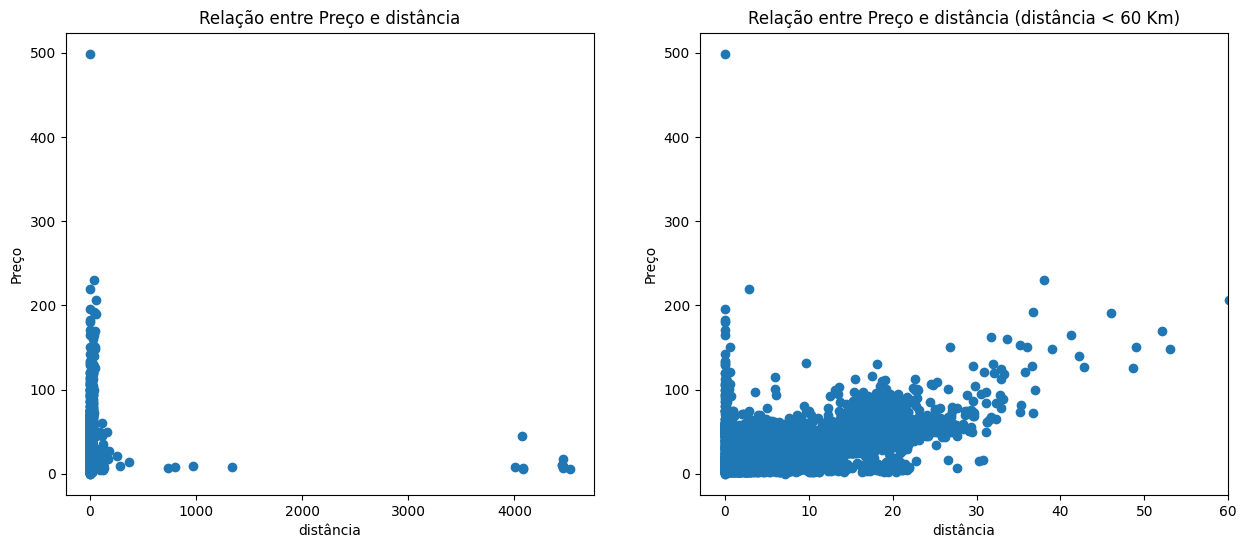

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

distances = data['distance_km']
fare = data['fare_amount']

axes[0].scatter(distances, fare)
axes[0].set_title('Relação entre Preço e distância')
axes[0].set_xlabel('distância')
axes[0].set_ylabel('Preço')

axes[1].scatter(distances, fare)
axes[1].set_title('Relação entre Preço e distância (distância < 60 Km)')
axes[1].set_xlabel('distância')
axes[1].set_ylabel('Preço')
axes[1].set_xlim(-3, 60)
# axes[1].set_ylim(0, 250)


Vamos que parece haver uma relação crescente entre o preço da viagem e
a distância percorrida. Vamos tentar eliminar os outliers
de corridas com distância muito grande, mas também aquelas
que percorreram distâncias muito curtas e que tiveram preços muito
altos.

In [ ]:
def outliers_indexes(df: pd.DataFrame, col: str, low_q=0.25, high_q=0.75):
    """
    Retorna os índices de outliers com base nos quantis dados
    """
    values = df[col].copy()
    q1 = values.quantile(low_q)
    q3 = values.quantile(high_q)
    IQR = q3 - q1
    upper_bound = q3 + 1.5 * IQR
    lower_bound = q1 - 1.5 * IQR

    outliers_filter = (df[col] > upper_bound) | (df[col] < lower_bound)
    return df[outliers_filter].index

# outliers de distância percorrida
distance_outliers = outliers_indexes(data, "distance_km", high_q=0.99)

# Remover outliers de corridas curtas e preço alto
temp_data = data[['fare_amount', 'distance_km']].copy()
temp_data['fare_per_km'] = temp_data['fare_amount'] / temp_data['distance_km']
fare_outliers = outliers_indexes(temp_data, 'fare_per_km', high_q=0.99)
# lista final dos outliers
outliers_indexes_list = list(set(distance_outliers).union(fare_outliers))

outliers_candidates = data.loc[outliers_indexes_list]
print(f"Quantidade de candidatos a outliers: {len(outliers_candidates)}")


Quantidade de candidatos a outliers: 1293


A escolha dos quantis altos se deu porque a média
e a mediana para amabas as features utlizadas são muito
distantes entre si, então ao usar os quartis tradicionais,
muitas corridas legítimas iriam acabar sendo consideradas outliers.
Desse modo, decidiu-se apenas remover registros considerados realmente
extremos.

(-17.0, 500.0)

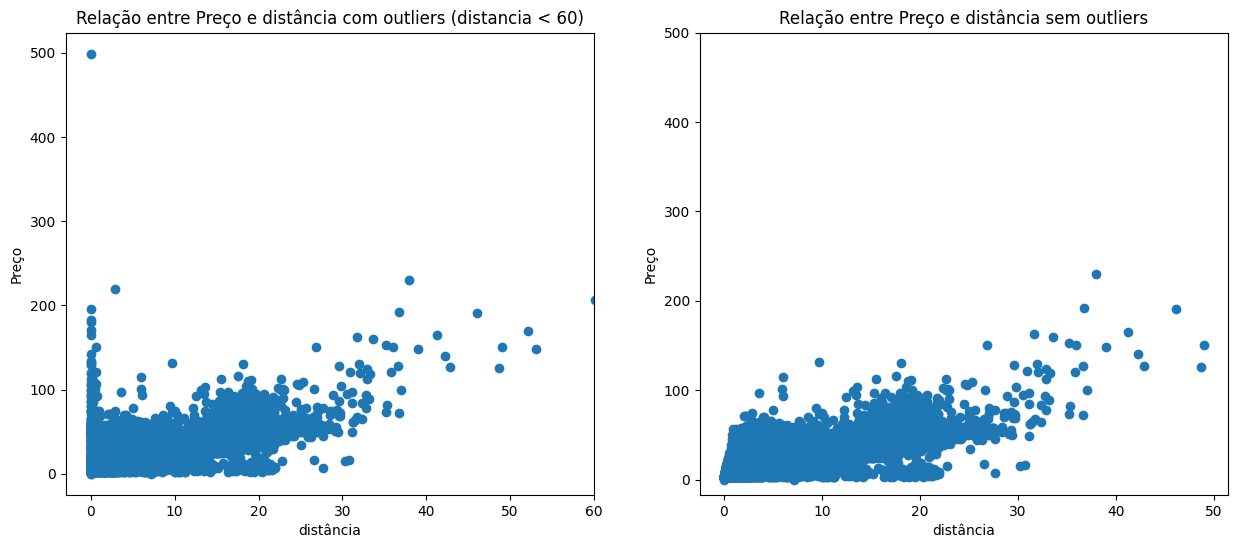

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

distances = data['distance_km']
fare = data['fare_amount']

clean_distances = data.drop(outliers_candidates.index)['distance_km']
clean_fare = data.drop(outliers_candidates.index)['fare_amount']

axes[0].scatter(distances, fare)
axes[0].set_title('Relação entre Preço e distância com outliers (distancia < 60)')
axes[0].set_xlabel('distância')
axes[0].set_ylabel('Preço')
axes[0].set_xlim(-3, 60)
# axes[0].set_ylim(0, 250)

axes[1].scatter(clean_distances, clean_fare)
axes[1].set_title('Relação entre Preço e distância sem outliers')
axes[1].set_xlabel('distância')
axes[1].set_ylabel('Preço')
axes[1].set_ylim(-17, 500)


Comparando os gráficos de dispersão com e sem outliers,
percebemos que no segundo caso conseguimos remover
em boa parte as corridas muito curtas, mas caras, e
as que percorreram distâncias muito grandes, limitando-as
para 50 km quase.

In [ ]:
# removendo outliers de perço/distância
df_final = data.drop(outliers_candidates.index)
# obter estatíscas do data set final
df_final.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,day,month,year,weekday,hour,feriado,dia_util
count,191829.000000,191829.000000,191829.000000,191829.000000,191829.000000,191829.000000,191829.000000,191829.000000,191829.000000,191829.000000,191829.000000,191829.000000,191829.000000,191829.000000
mean,11.289929,-73.975686,40.750832,-73.974701,40.751152,1.690365,3.372549,15.699091,6.283012,2011.748286,3.049544,13.494430,0.022546,0.695479
std,9.419306,0.035932,0.028431,0.036007,0.032258,1.305758,3.597874,8.687285,3.440668,1.862688,1.946491,6.515304,0.148452,0.460206
min,0.010000,-75.387785,39.605438,-75.417737,39.607967,1.000000,0.002545,1.000000,1.000000,2009.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992282,40.736515,-73.991601,40.735393,1.000000,1.295446,8.000000,3.000000,2010.000000,1.000000,9.000000,0.000000,0.000000
50%,8.500000,-73.982152,40.753315,-73.980597,40.753767,1.000000,2.193638,16.000000,6.000000,2012.000000,3.000000,14.000000,0.000000,1.000000
75%,12.500000,-73.968567,40.767554,-73.965675,40.768337,2.000000,3.957364,23.000000,9.000000,2013.000000,5.000000,19.000000,0.000000,1.000000
max,230.000000,-71.896038,42.478467,-71.836652,42.464187,6.000000,49.003731,31.000000,12.000000,2015.000000,6.000000,23.000000,1.000000,1.000000


In [ ]:
gen_heatmap(df_final, "heatmap_combined_final.html")

![heatmap_final](images/final_map.png)

Com a remoção dos dados considerados inconsistentes, acabamos
limitando nossos dados à região dos três estados (Nova York,
Nova Jersey e Connecticut), Pensivânia e Massachussets.
No entanto, ainda temos cerca de 190 mil registros na
base de dados dos 200 mil originais, o que significa que nossos dados eram relamente
mais representativos desses locais.

# Análise Exploratória dos Dados

Possíveis perguntas a serem respondidas


1. Quais features estão mais correlacionadas com a feature alvo?
2. O dia das semana em que a corrida ocorre influencia o preço? Como será o comportamento da média do preço ao longo dos dias?
4. E quanto a hora do dias? Qual será a distribuição da média dos preços ao longo das horas de um dia? Há horários de picos?
5. Em dias de feriado ou final de semana, o preço tende a mudar?
3. Geralmente os serviços tendem a ficar mais caros ao longo dos anos. Será que há crescimento no preço médio ao longo dos anos
6. Na teoria, o preço de um Uber não é influenciado pela quantidade de passageiros que irão embarcar. Será que isso se confirma aqui?
7. A distância percorrida influencia o preço? Se sim, qual seria a relação?


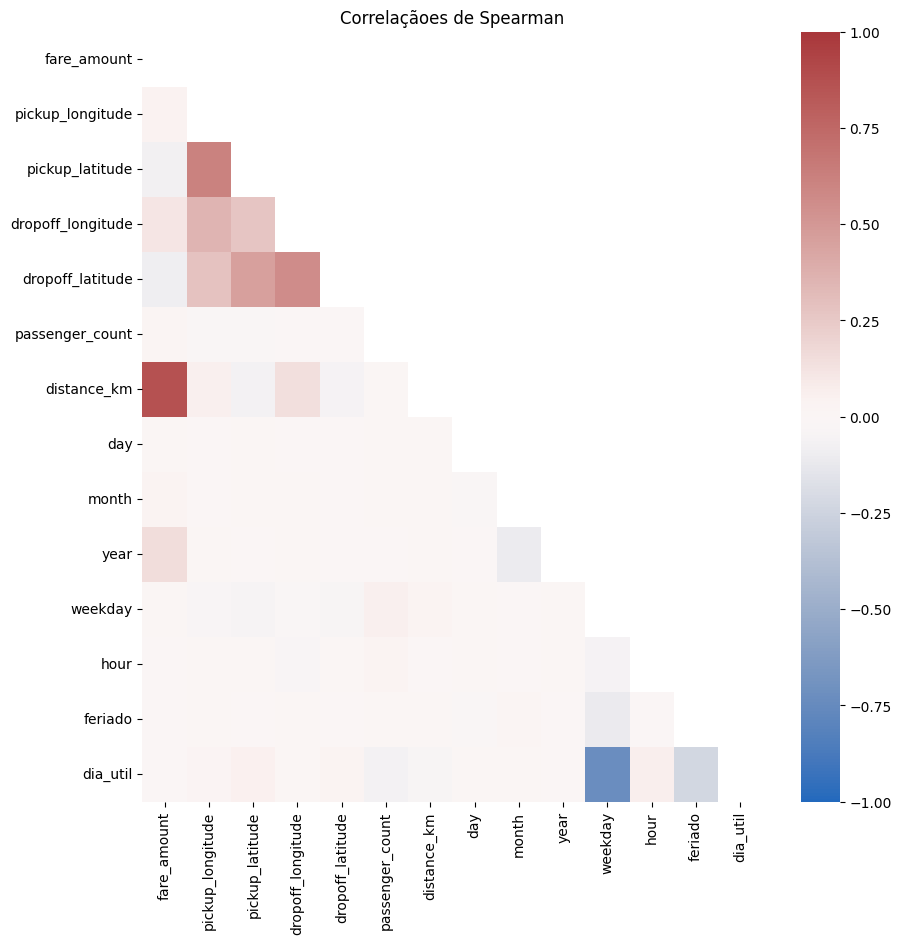

In [ ]:
# Código emprestado do professor :)
plt.figure(figsize=(10, 10))
df_num = df_final.select_dtypes(include=['number', 'bool'])
mask = np.triu(np.ones_like(df_num.corr(), dtype=bool))
sns.heatmap(df_num.corr(method = 'spearman'), annot=False, mask=mask, vmin=-1, vmax=1, cmap = "vlag")
plt.title("Correlaçãoes de Spearman")
plt.show()

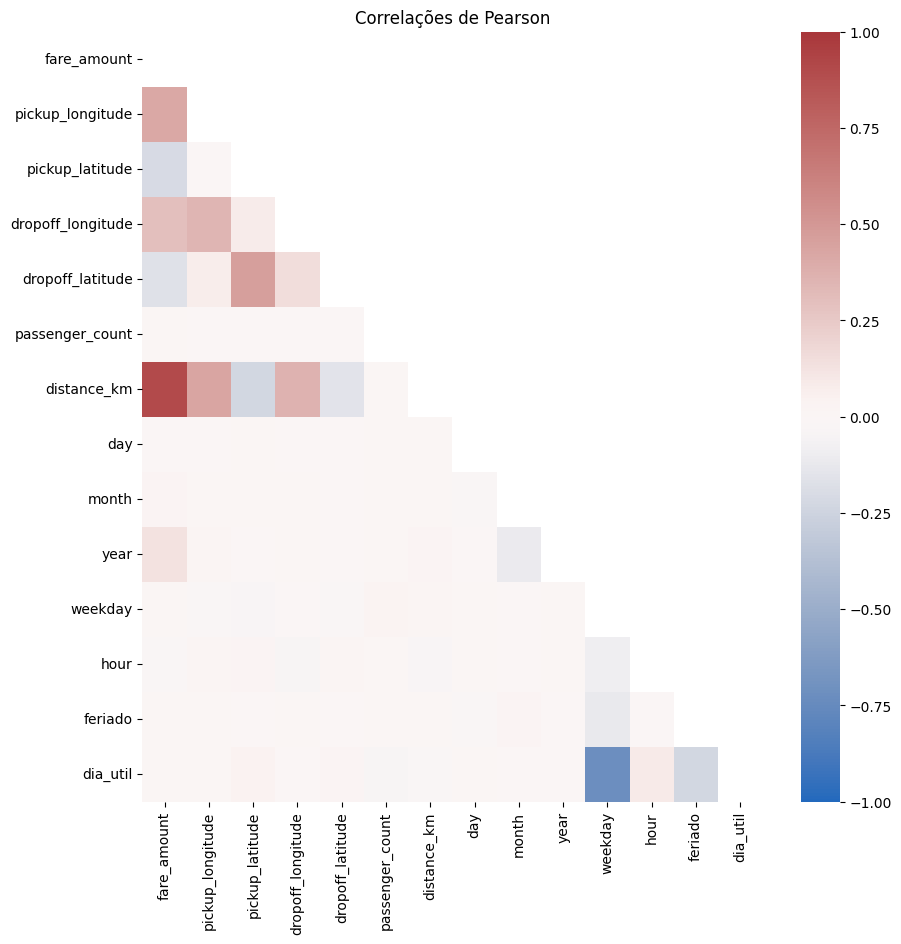

In [ ]:
# Código emprestado do professor :)
plt.figure(figsize=(10, 10))
df_num = df_final.select_dtypes(include=['number', 'bool'])
mask = np.triu(np.ones_like(df_num.corr(), dtype=bool))
sns.heatmap(df_num.corr(method = 'pearson'), annot=False, mask=mask, vmin=-1, vmax=1, cmap = "vlag")
plt.title("Correlações de Pearson")
plt.show()

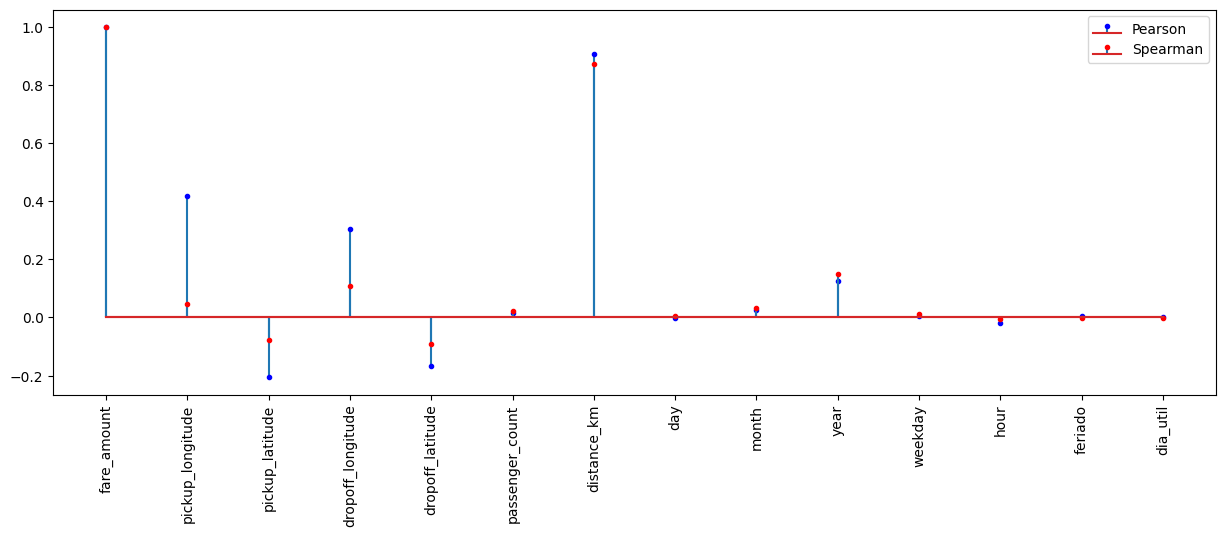

In [ ]:
# Código emprestado do professor :)
plt.figure(figsize = (15,5))
plt.stem(df_num.corr(method = 'pearson')['fare_amount'], label = 'Pearson', markerfmt = '.b')
plt.stem(df_num.corr(method = 'spearman')['fare_amount'], label = 'Spearman', markerfmt = '.r')
plt.xticks(range(len(list(df_num.columns))), list(df_num.columns), rotation = 'vertical')
plt.legend()

plt.show()

In [ ]:
df_final.corr(method='spearman').loc['fare_amount']

fare_amount          1.000000
pickup_longitude     0.046187
pickup_latitude     -0.077164
dropoff_longitude    0.109825
dropoff_latitude    -0.091309
passenger_count      0.022853
distance_km          0.872023
pickup_dt            0.156338
day                  0.003701
month                0.032164
year                 0.150970
weekday              0.013413
hour                -0.005843
feriado             -0.003339
dia_util            -0.002372
Name: fare_amount, dtype: float64

In [ ]:

df_final.corr(method='pearson').loc['fare_amount']

fare_amount          1.000000
pickup_longitude     0.417332
pickup_latitude     -0.205108
dropoff_longitude    0.302897
dropoff_latitude    -0.165643
passenger_count      0.013757
distance_km          0.906211
pickup_dt            0.129999
day                 -0.000560
month                0.024357
year                 0.125485
weekday              0.004741
hour                -0.019687
feriado              0.003332
dia_util             0.000076
Name: fare_amount, dtype: float64

Ao observar as correlações tanto de Spearman quanto de Pearson,
podemos constatar que algumas features praticamente não estão
correlacionadas com a feature alvo, seno elas as de tempo,
com exceção do ano da corrida, as que dizem se a corrida
ocorreu num dia útil ou não e a contagem de passsageiros da corrida.

Isso já responde algumas das questões que haviamos levantado, dando
uma respota negativas a elas. No entanto, vamos ainda ver a distribuição
do preço quanto a essas features e o comportamento do preço médio.

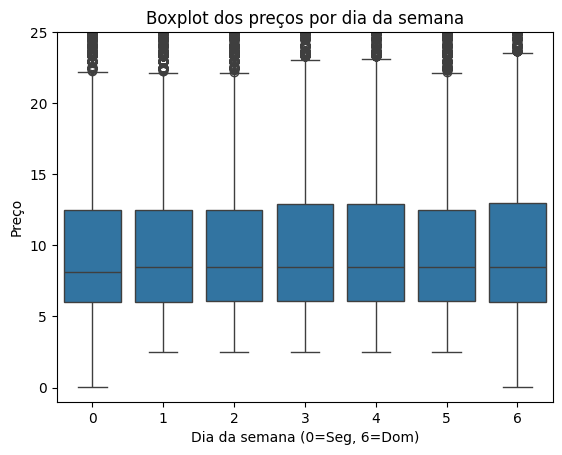

In [ ]:
sns.boxplot(x='weekday', y='fare_amount', data=df_final)
plt.title('Boxplot dos preços por dia da semana')
plt.xlabel('Dia da semana (0=Seg, 6=Dom)')
plt.ylabel('Preço')
plt.ylim(-1, 25)
plt.show()


A partir da vizualização dos boxplot dos preços por dia da semana, não
parece haver diferença significativa entre as distribuições dos preços
em cada dia. Analisando as médias individualmente, obtemos o seguinte

Amplitude preço médio na semana: 0.6634119951441679


Text(0.5, 1.0, 'Preço Médio por dia da semana')

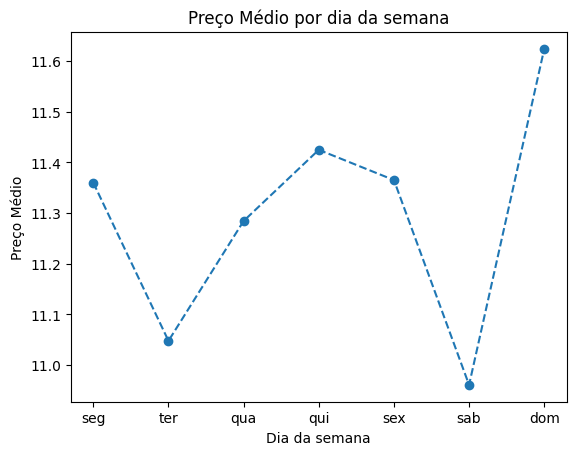

In [ ]:
dias = ['seg', 'ter', 'qua', 'qui', 'sex', 'sab', 'dom']
df_group_weekday = df_final.groupby(by='weekday')['fare_amount']
df_group_weekday_mean = df_group_weekday.mean()
print(f"Amplitude preço médio na semana: {df_group_weekday_mean.max() - df_group_weekday_mean.min()}")
#df_group_weekday.values
plt.plot(df_group_weekday_mean.index, df_group_weekday_mean.values, '--o')
plt.xticks(range(7), dias)
plt.xlabel("Dia da semana")
plt.ylabel("Preço Médio")
plt.title("Preço Médio por dia da semana")

O comportameto da média do preço da corrida ao longo da semana
é claramente não linear. Ele atinge picos altos na segunda, quinta e domingo,
e picos baixos nas terças e sábados.
A amplitude dele não é muito alta, sendo menor do que 1 dólar.

Amplitude do preço médio num dia: 5.366730634921902


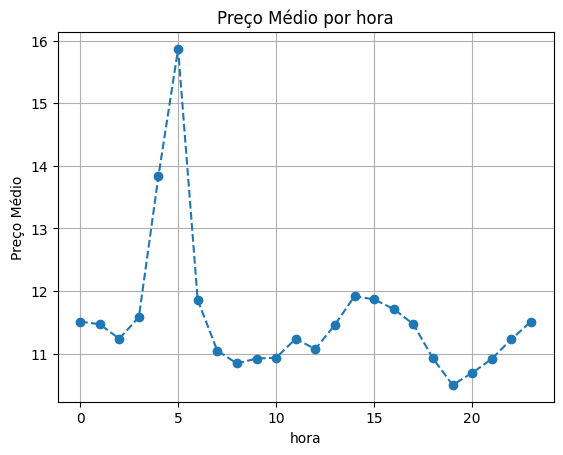

In [ ]:
prince_mean_per_hour = df_final.groupby(['hour'])['fare_amount'].mean()
print(f"Amplitude do preço médio num dia: {prince_mean_per_hour.max() - prince_mean_per_hour.min()}")
plt.plot(prince_mean_per_hour.index, prince_mean_per_hour.values, '--o')
plt.xlabel("hora")
plt.ylabel("Preço Médio")
plt.title("Preço Médio por hora")
plt.grid()

Observa-se que há bem mais variação no preço das corridas ao longo
das horas de um dia, com o preço médio tendo uma amplitude de
aproximadamente de 5 dólares.

Vamos que há um grande pico no preço médio durante a madrugada,
o que parece coerente, já que há menos circulação de transportes
públicos, e a oferta de motoristas é geralmente menor. Um outro pico
menor ocorre no período da tarde, talvez por haver movimetação
de pessoas voltando de trabalho, escola, faculdade, etc.

Observemos também que a média do preço segue um padrão não linear ao longo do dia,
como esperado, pois alguns horários serão de picos, enquanto outros de baixa.

amplitudes dos preços médios a cada hora por dia da semana
seg: 6.47	ter: 4.07	qua: 5.23	qui: 4.51	sex: 4.7	sab: 0.34	dom: 4.0	


Text(0, 0.5, 'preço')

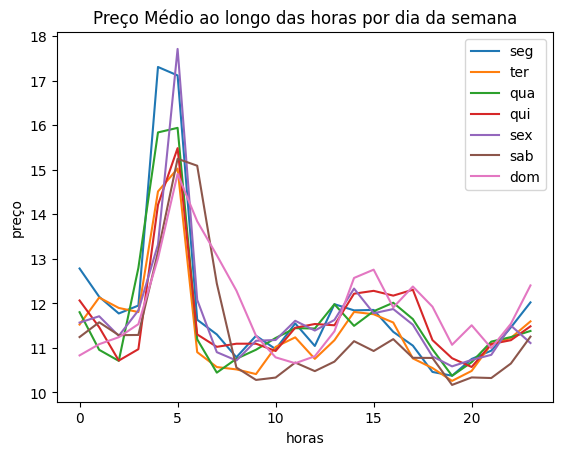

In [ ]:
dias = ['seg', 'ter', 'qua', 'qui', 'sex', 'sab', 'dom']
price_group_day_hour = df_final.groupby(['weekday', 'hour'])['fare_amount'].mean().unstack()
amplitudes = str()
for i in range(7):
    plt.plot(price_group_day_hour.columns, price_group_day_hour.values[i], label=f'{dias[i]}')
    amplitudes += f'{dias[i]}: ' + f'{
        np.round(
            price_group_day_hour.values[i].max() - price_group_day_hour[i].min(), 2
        )
    }\t'
print("amplitudes dos preços médios a cada hora por dia da semana")
print(amplitudes)
plt.legend()
plt.title('Preço Médio ao longo das horas por dia da semana')
plt.xlabel("horas")
plt.ylabel('preço')

Acima vemos que o comportamento do preço médio ao longo das horas tem o mesmo
padrão independente do dia semana.

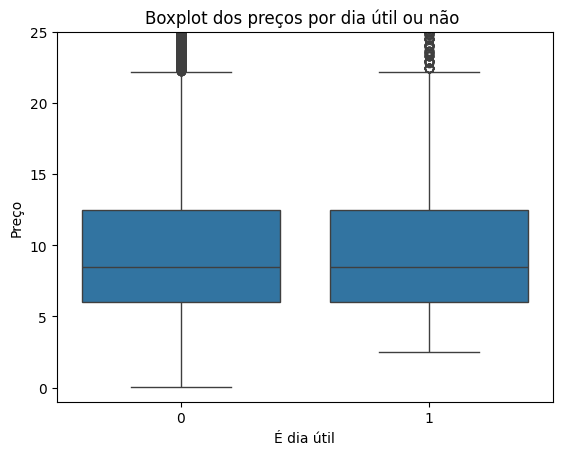

In [ ]:
price_mean_per_isutil = df_final.groupby(['dia_util', 'hour'])['fare_amount'].mean().unstack()
sns.boxplot(x='feriado', y='fare_amount', data=df_final)
plt.title('Boxplot dos preços por dia útil ou não ')
plt.xlabel('É dia útil')
plt.ylabel('Preço')
plt.ylim(-1, 25)
plt.show()

As distribuições dos preços baseado no dia ser útil ou não parecem
ser bem similares, sem diferença entre os seus quartis .
Contudo, observa-se que o limite inferior dos preços
nos dias úteis é maior. Talvez por haver menos movimentação na rua
nos feriados e final de semana (a depender do feriado também), o aplicativo
deve oferecer algumas corridas com preços mais baixos, ou também promocionais.

In [ ]:
price_group_isutil = df_final.groupby(['dia_util'])['fare_amount'].mean()
print(price_group_isutil)

dia_util
0    11.288841
1    11.290406
Name: fare_amount, dtype: float64


Podemos observar pelos valores que talvez não haja
diferença significativa entre as médias dos preços
condicionado ao dia ser útil ou não. Essa diferença
pode - talvez -  ser mais perceptível no universo das
corridas mais baratas, visto o boxplot anterior.

In [ ]:
price_group_isutil_least5 = df_final[df_final['fare_amount'] < 6].groupby(['dia_util'])['fare_amount'].mean()
print(price_group_isutil_least5)

dia_util
0    4.721219
1    4.730312
Name: fare_amount, dtype: float64


Como podemos observar, mesmo no uiverso das corridas mais baratas, a diferença
entre as médias não parece ser significativa

Vamos observar também se a comportamento diferente para o preço
médio ao longo de um dia condicionado ao fato do dia ser útil ou
não.

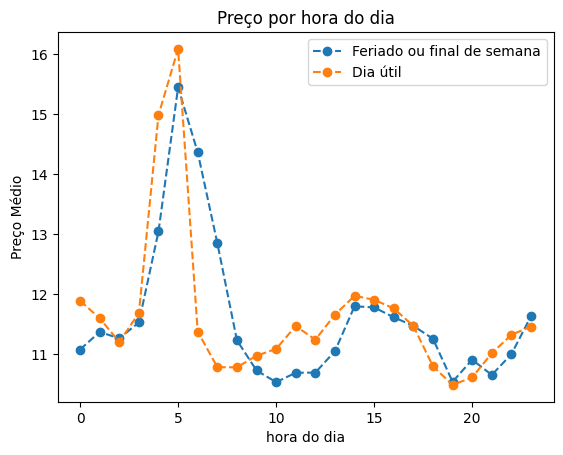

In [ ]:
plt.plot(price_mean_per_isutil.columns, price_mean_per_isutil.values[0], '--o', label='Feriado ou final de semana')
plt.plot(price_mean_per_isutil.columns, price_mean_per_isutil.values[1], '--o', label='Dia útil')
plt.xlabel("hora do dia")
plt.ylabel("Preço Médio")
plt.title("Preço por hora do dia")
plt.legend()

O comportamento do preço médio ao longo das horas condicionado ao
dia ser útil ou não é a mesma se não tivéssemos condicionado.
Alguns comportamentos que podemos observar de diferentes quanto ao
condicionamento é que preços nos dias úteis, o preço médio cai mais
rápido no período entre 5 e 7 da manhã, sendo que nos dias não úteis
ele se mantém em queda até as 10 da manhã. O crescimento após esses
períodos também se dá de forma mais aceleradas, nos dias úteis. Nas horas
que se sucedem, o preço mantém um comportamento sem muitas distinções em
ambos os casos.

Quanto ao núemro de passageiros em uma corrida, vamos adotar os
mesmos procedimentos até então: ver a distribuição dos preços
pelo número de passageiros e o comportamento do preço médio

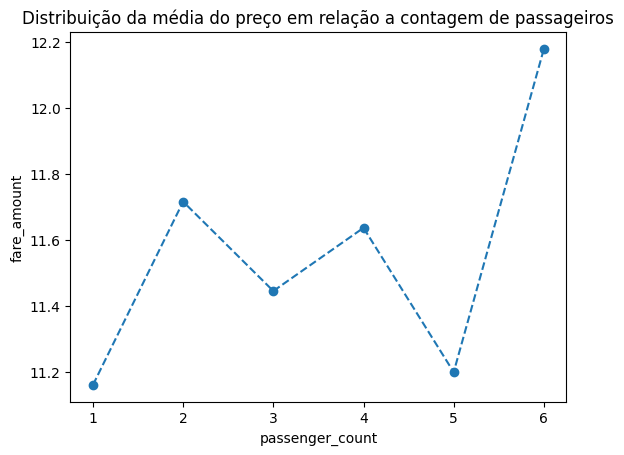

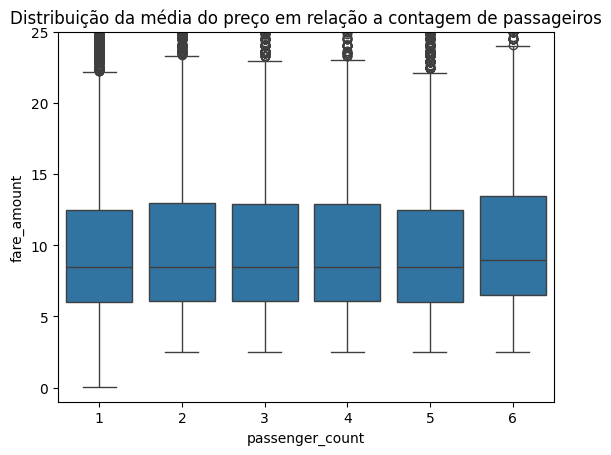

In [ ]:
def group_and_plot_mean(df: pd.DataFrame, by: str, target_col: str, title: str = ''):
    grouped = df.groupby(by=by)[target_col].mean()
    plt.plot(grouped.index, grouped.values, '--o')
    plt.xlabel(by)
    plt.ylabel(target_col)
    if title:
        plt.title(title)
    else:
        plt.title(f"{target_col} x {by} plot")
    plt.show()
    sns.boxplot(x=by, y=target_col, data=df)
    plt.ylim(-1, 25)
    if title:
        plt.title(title)
    else:
        plt.title(f"{target_col} x {by} boxplot")

group_and_plot_mean(df_final, 'passenger_count', 'fare_amount', title="Distribuição da média do preço em relação a contagem de passageiros")

Os quartis entre os grupos são bem parecidos, com exceção das viagens
com 6 passageiros, que são um pouco mais elevadas. Vemos também que corridas
com 6 passageiros, em média, são mais caras, no tentanto, o comportamento
do preço médio em relação ao número dos passageiros não é linear tampouco
crescente.

Esse padrão é, de certa forma, não esperado, e é difícil dizer
qualitivamente como o número de passageiros afeta o preço das
corridas, a menos do número de passageiros ser maior ou igual a 6

Vamos agora tentar responder as perguntas sobre as features que realmente
possuem alguma correlação com o alvo, a começar pelo ano da corrida.

Text(0.5, 1.0, 'Preço Médio por ano')

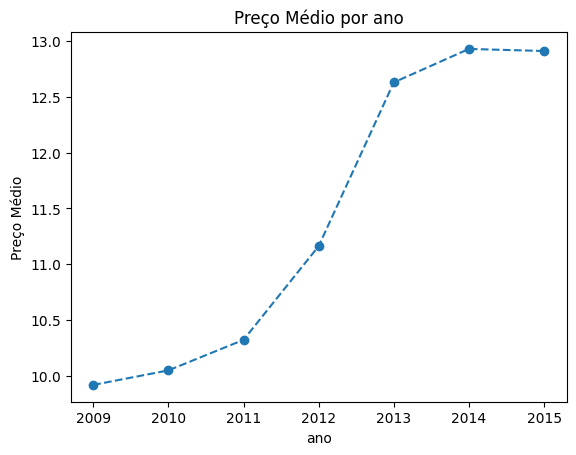

In [ ]:
price_mean_per_year = df_final.groupby(['year'])['fare_amount'].mean()
plt.plot(price_mean_per_year.index, price_mean_per_year.values, '--o')
plt.xlabel("ano")
plt.ylabel("Preço Médio")
plt.title("Preço Médio por ano")

Visto o gráfico acima, podemos constatar o preço
médio da corrida aumenta no decorrer dos anos,
como havíamos presumido,
o que deve ocorrer principalmente devido a
efeitos inflacionários.

Indo para as distâncias, por ser um atributo contínuo,
podemos fazer um gráfico de dispersão entre o preço e
a distância

Text(0, 0.5, 'Preço (US$)')

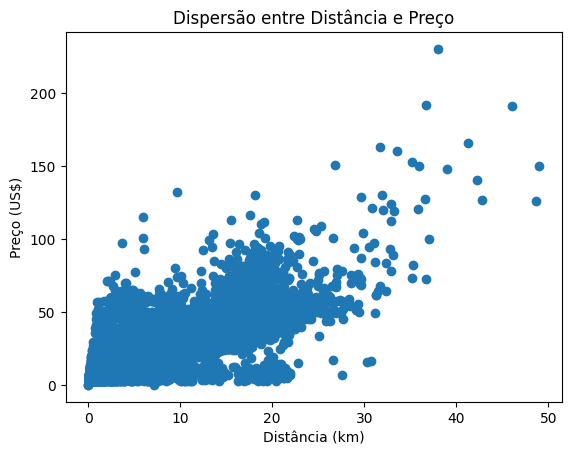

In [ ]:
plt.scatter(df_final['distance_km'], df_final['fare_amount'])
plt.title("Dispersão entre Distância e Preço")
plt.xlabel('Distância (km)')
plt.ylabel("Preço (US$)")

Visto o gráfico, percebemos que possivelmente há uma alta correlação entre os preços
e as distâncias percorridas, como esperado. Essa relação é crescente e parece ser
bem ajustada por um modelo linear. Corridas de uber, em princípio, são mais caras
conforme a distância a aumenta, mas isso não necessariamente uma regra:
há corridas relativamente curtas com preços altos, e também corridas
longas, mas baratas.

Para o prmeiro caso, talvez outros fatores estajam envolvidos, como
a questão da precificação dinâmica do aplicativo a depender do local
e de quando a corrida ocorre, pois como haviámos visto, em alguns
dias da semana e horas do dia as corridas podem ficar um pouco mais
caras. No segundo caso, um explicação plausível são as promoções
e cupons, capazes de baratear significativamente corridas que antes
seriam caras devido a distância.

Vamos observar as features de coordenadas

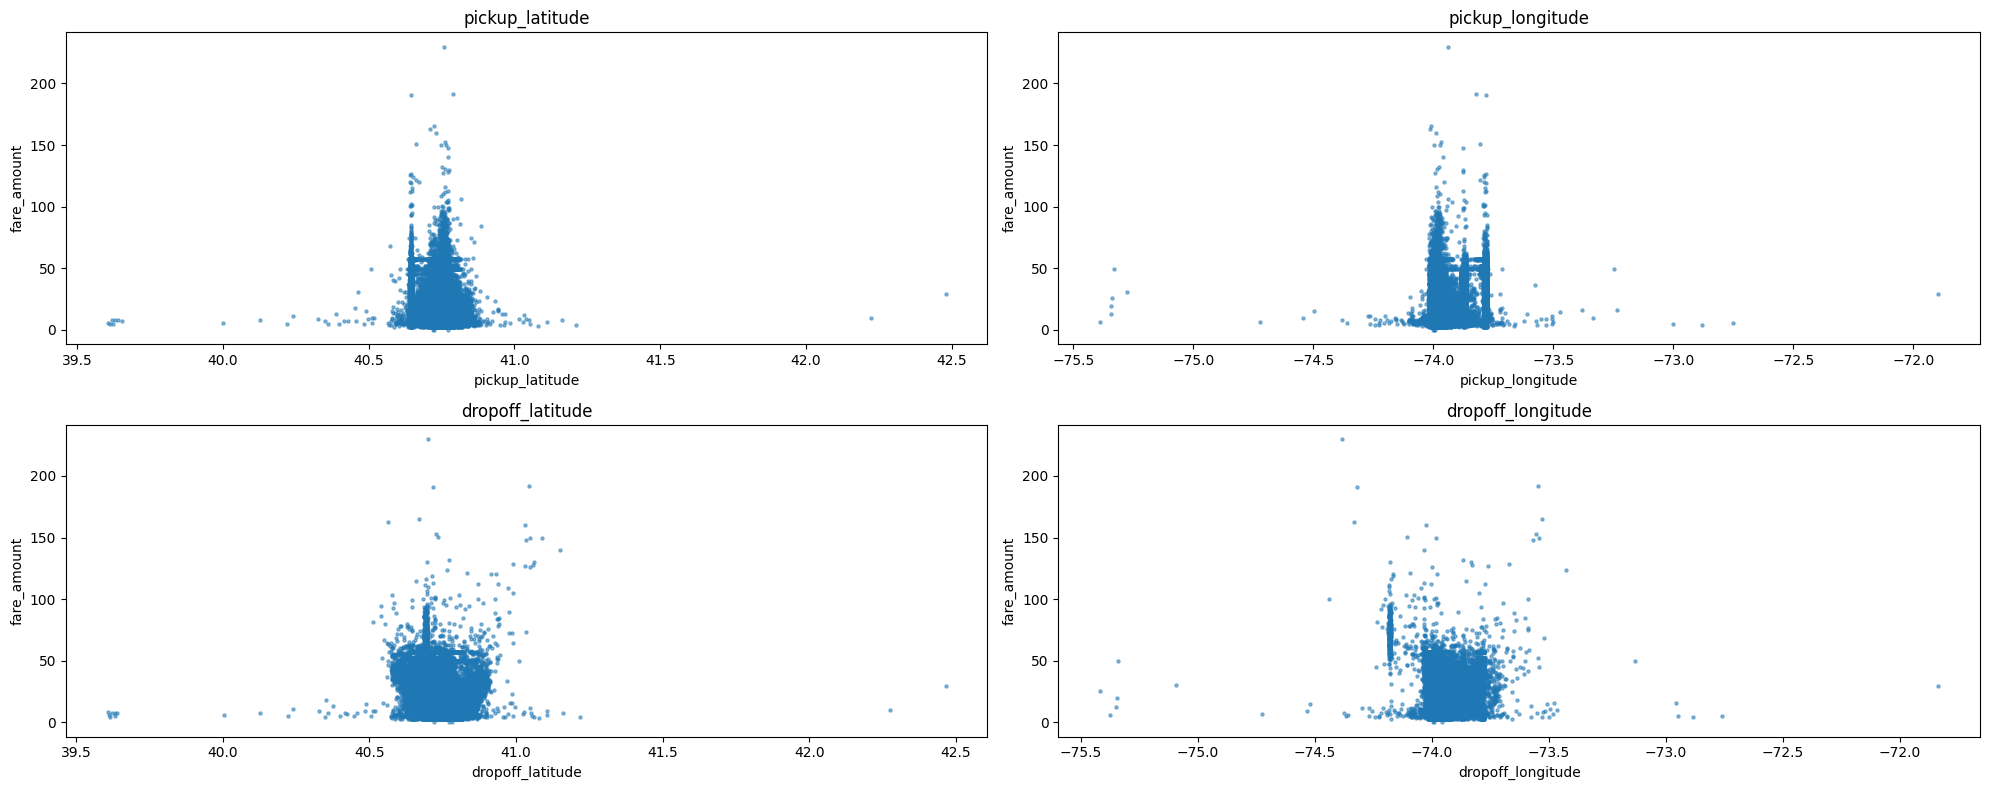

In [ ]:
df_coords = df_final[coord_columns + ['fare_amount']]
n_cols = 2
n_features = df_coords.shape[1] - 1
n_rows = -(-n_features // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(df_coords.columns):
    if col == 'fare_amount':
        continue
    axes[i].scatter(df_coords[col], df_coords['fare_amount'], alpha=0.5, s=5)
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("fare_amount")

# Se sobrar espaço na grade, remover eixos extras
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

As features de coordenadas possuiam correlações
fracas com o preço da corrida, e podemos ver pelas
dispersões que os dados aparentam ter bastante ruído.
No gráfico da correlação de spearman, vemos também
que essas variáveis estão correlacionadas entre si.
Portanto, iremos utilizar a técnica de PCA para
criar componentes não correlacionadas que agreguem
as informações dessas features e que gerem menos
ruído.

Variância explicada pelo PCA: [0.39355922 0.31373781]


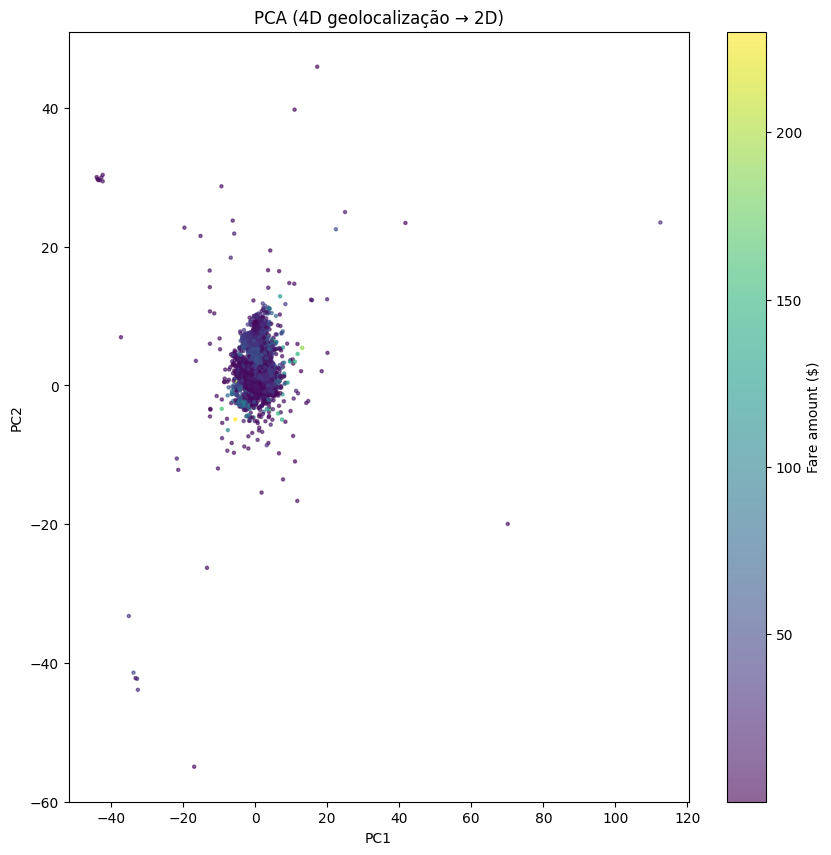

In [ ]:
# Partes desses trecho foram feitos com auxílio de um LLM

pca = PCA(2)
X_pca = StandardScaler().fit_transform(df_final[coord_columns])
coords_pca = pca.fit_transform(X_pca)
df_pca = pd.DataFrame(coords_pca, columns=['PC1', 'PC2'])
df_pca['fare_amount'] = df_final['fare_amount'].values
print(f"Variância explicada pelo PCA: {pca.explained_variance_ratio_}")

plt.figure(figsize=(10,10))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'],
                      c=df_pca['fare_amount'], cmap='viridis', s=5, alpha=0.6)

plt.colorbar(scatter, label="Fare amount ($)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (4D geolocalização → 2D)")
plt.show()

In [ ]:
df_pca.corr(method='spearman')['fare_amount']

PC1            0.005487
PC2            0.232318
fare_amount    1.000000
Name: fare_amount, dtype: float64

A segunda componente principal chega a ter correlação com alvo maior até que das features
originais.
Espera-se que a primeira componente principal esteja ligada
a variância geográfica das corrida, já que estamos tratando
de coordenadas. Outrora, o segundo PC, como já observado,
parece conter algum padrão que explica melhor a varância
no preço das corridas visto que o seu valor de correlação
maior. Na vizualização em dimensão baixa, parece haver
concentrações de pontos atrelados a certos preços, de
forma que essas regiões parecem mudar principalmente em
relação ao PC2, o que explicaria aquela correlação
obtida.

Vamos observar o comportamento do preço nas componentes
separadamente.

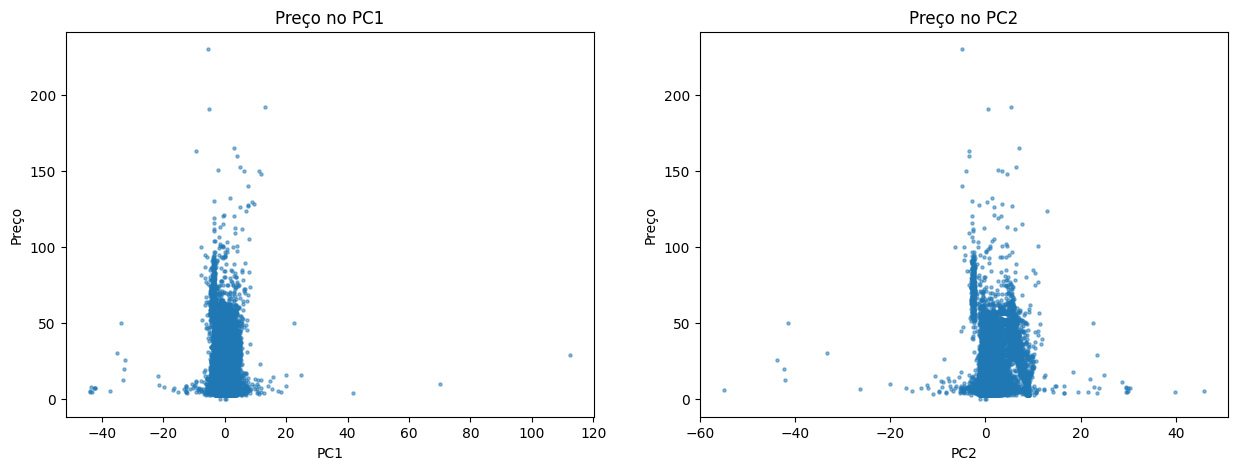

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for col, ax in enumerate(axes):
    pc_name = f'PC{col+1}'
    ax.scatter(df_pca[pc_name], df_pca['fare_amount'], alpha=0.5, s=5)
    ax.set_title(f"Preço no {pc_name}")
    ax.set_ylabel('Preço')
    ax.set_xlabel(pc_name)

Observa-se que as componentes principais conseguiram
remover parte do ruído que havia nos dados de algumas
coordenadas mantendo seu padrão

No geral, as features geográficas são mais difíceis de serem interpretadas,
pois a informação que elas carregam sobre os preços da corrida devem-se,
provavelmente, a zonas da cidade em que houve o embarque e o desembarque,
sendo essa uma informação mais complexa de se extrair. Algoritmos de agrupamento
talvez fossem úteis aqui para agrupar os valores de latitude e longitude
dos embarques e desembarque, porém, deixaremos isso de fora no momento,
pois temos um prazo de entrega.

Portanto, vimos que as distâncias, o ano e a hora do dia parecem ser úteis
para explicar o preço de uma corrida. Quanto as features geográficas,
iremos utilizá-las como preditores também, mas esperando que não sejam
importantes para modelos lineares. Os modelos baseados em árvores talvez
tenham a capacidade de realizar a partição no expaço das covariáveis
geográficas, de modo a melhor capturar a variação do preço da
corrida com base nas "zonas" de embarque e desembarque.

# Modelos

Nessa seção, iremos realizar o treinamento dos modelos utilizando as features que
consideramos mais importantes para predizer o preço da corrida.

- `distance_km`
- `year`
- `pickup_latitude`
- `pickup_longitude`
- `dropoff_latitude`
- `dropoff_longitude`
- `hour`

A metodologia adota será


- Separar os dados em conjunto de treino e de teste

- Para fins de experimentação, usaremos a validação cruzada acompanhada de duas
pipelines possíveis. A primeira irá utlizar as colunas selecionadas, padronizando-as
em cada fold e fazendo a validação. A segunda, antes de padronizar, irá fazer
o PCA das features geográficas, seguindo então para padronização e validação do
modelo.

- Iremos medir o tempo da validação cruzada ou treinamento, o tempo
de predição no conjunto de teste e a raíz quadrada do MSE de teste.

- O melhor modelo será escolhido de forma a equilibrar performance de
treinamento e o MSE.

In [ ]:
df_val = df_final[['fare_amount', 'distance_km', 'year', *coord_columns, 'hour']]

X_train, X_test, y_train, y_test = train_test_split(df_val.drop(columns=['fare_amount']),
                                                    df_val['fare_amount'],
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
alpha_params = {'alpha':[0.001, 0.01, 0.1, 0.5, 1, 10, 50, 75, 100]}

# Essa classe tem o objetivo de facilitar a realização dos testes
class ModelTrainer:
    _base_model:        BaseEstimator                  # Estimador básico
    model_fit:          GridSearchCV       = None              # Modelo estimado com validação cruzada e treinado
    cv_timedelta :      datetime.timedelta = None    # Tempo de validação cruzada
    train_timedelta:    datetime.timedelta = None  # Tempo de treinamento
    cv: False

    def __init__(self, base_model):
        self._base_model = base_model

    def __rename_paramkeys(self, param_grid: dict[str, object]):
        # Fazer o renomeanto da grande das chaves do param_grid para usar na pipeline
        if not param_grid:
            return
        new_keys = ['estimator__' + name for name in param_grid.keys()]
        return {key:val for key, val in zip(new_keys, param_grid.values())}


    def train(self, X, y, **kwargs):
        """
        Realiza a pipeline de treinamento do modelo nas seguintes fases

        1 - Cria uma pipeline de padronização e criação do estimador
        2 - faz o fit do modelo usando validação cruzada
        3 - registra o tempos de validação e treinamenot
        """

        # Foi feito uso de um LLM para integrar o uso do PCA a pipeline
        if 'coord_cols' in kwargs:
            coord_cols = kwargs.get('coord_cols', None)
            kwargs.pop('coord_cols')
            other_cols = [col for col in X.columns if col not in coord_cols]
            preprocessor = ColumnTransformer(
                transformers=[
                    ('geo_pca', Pipeline(
                        [('scaler', StandardScaler()), ('pca', PCA(n_components=2))]
                    ), coord_cols),
                    ('others', StandardScaler(), other_cols)
                ]
            )
            model_pipe = Pipeline([('preprocess', preprocessor), ('estimator', self._base_model)])
        else:
            model_pipe = Pipeline([('scaler', StandardScaler()), ('estimator', self._base_model)])

        if kwargs:
            if 'param_grid' in kwargs:
                param_grid = self.__rename_paramkeys(kwargs.get('param_grid', None))
                kwargs.pop('param_grid')
                # Fazer a validação Cruzada
                self.model_fit = GridSearchCV(
                    model_pipe,
                    param_grid=param_grid,
                    cv=kwargs.pop('cv', 5),
                    **kwargs
                )
                self.cv = True
            else:
                self.model_fit = model_pipe
                self.cv = False
        else:
            self.model_fit = model_pipe
            self.cv = False

        if self.cv:
            start = datetime.datetime.now()
            self.model_fit.fit(X, y)
            finish = datetime.datetime.now()
            self.cv_timedelta = finish - start

            start = datetime.datetime.now()
            self.model_fit.best_estimator_.fit(X, y)
            finish = datetime.datetime.now()
            self.train_timedelta = finish - start
        else:
            start = datetime.datetime.now()
            self.model_fit.fit(X, y)
            finish = datetime.datetime.now()
            self.train_timedelta = finish - start

    def mse(self, X, y):
       start = datetime.datetime.now()
       error =  MSE(y, self.model_fit.predict(X))
       finish = datetime.datetime.now()
       pred_time = finish - start
       return error, pred_time

    def gen_summry(self):
        if self.cv:
            print(f"Tempo de validação cruzada: {self.cv_timedelta}")
            print(f"Tempo de treinamento: {self.train_timedelta}")
            print(f"Melhor estimador: {self.model_fit.best_estimator_}")
        else:
            print(f"Tempo de treinamento: {self.train_timedelta}")

    def sumary_pred_time(self, X, y, squarert_mse=False):
        error, time = self.mse(X, y)
        if not squarert_mse:
            print(f"MSE: {error}")
        else:
            print(f"sqrt(MSE): {np.sqrt(error)}")
        print(f"Tempo de Predição: {time}")

def run_test(model, X_train, y_train, X_test, y_test, square_root_mse=False, **kwargs):
    Model = ModelTrainer(model)
    Model.train(X_train, y_train, **kwargs)
    Model.gen_summry()
    Model.sumary_pred_time(X_test, y_test, square_root_mse)
    return Model.model_fit

## Modelos Lineares

In [ ]:
LR1 = run_test(
    LinearRegression(),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
)

Tempo de treinamento: 0:00:00.014649
sqrt(MSE): 1.469059150959091
Tempo de Predição: 0:00:00.002659


In [ ]:
LR2 = run_test(
    LinearRegression(),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    coord_cols=coord_columns,
)

Tempo de treinamento: 0:00:00.062953
sqrt(MSE): 1.4672657643812628
Tempo de Predição: 0:00:00.010026


In [ ]:
Ridge1 = run_test(
    Ridge(),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    param_grid = alpha_params
)

Tempo de validação cruzada: 0:00:01.382440
Tempo de treinamento: 0:00:00.023601
Melhor estimador: Pipeline(steps=[('scaler', StandardScaler()), ('estimator', Ridge(alpha=10))])
sqrt(MSE): 1.4644366907141526
Tempo de Predição: 0:00:00.003797


In [ ]:
Ridge2 = run_test(
    Ridge(),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    param_grid = alpha_params,
    coord_cols=coord_columns,
)

Tempo de validação cruzada: 0:00:02.998266
Tempo de treinamento: 0:00:00.049815
Melhor estimador: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('geo_pca',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['pickup_latitude',
                                                   'pickup_longitude',
                                                   'dropoff_latitude',
                                                   'dropoff_longitude']),
                                                 ('others', StandardScaler(),
                                                  ['distance_km', 'year',
                                            

In [ ]:
Lasso1 = run_test(
    Lasso(),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    param_grid=alpha_params,
)

Tempo de validação cruzada: 0:00:02.564502
Tempo de treinamento: 0:00:00.049475
Melhor estimador: Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator', Lasso(alpha=0.001))])
sqrt(MSE): 1.4643620189590003
Tempo de Predição: 0:00:00.006107


In [ ]:
Lasso2 = run_test(
    Lasso(),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    param_grid=alpha_params,
    coord_cols=coord_columns,
)

Tempo de validação cruzada: 0:00:05.256611
Tempo de treinamento: 0:00:00.160751
Melhor estimador: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('geo_pca',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['pickup_latitude',
                                                   'pickup_longitude',
                                                   'dropoff_latitude',
                                                   'dropoff_longitude']),
                                                 ('others', StandardScaler(),
                                                  ['distance_km', 'year',
                                            

In [ ]:
EN1 = run_test(
    ElasticNet(),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    param_grid=alpha_params
)

Tempo de validação cruzada: 0:00:02.592716
Tempo de treinamento: 0:00:00.048873
Melhor estimador: Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator', ElasticNet(alpha=0.001))])
sqrt(MSE): 1.464330347917391
Tempo de Predição: 0:00:00.006521


In [ ]:
EN2 = run_test(
    ElasticNet(),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    param_grid=alpha_params,
    coord_cols=coord_columns,
)

Tempo de validação cruzada: 0:00:05.495382
Tempo de treinamento: 0:00:00.144271
Melhor estimador: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('geo_pca',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['pickup_latitude',
                                                   'pickup_longitude',
                                                   'dropoff_latitude',
                                                   'dropoff_longitude']),
                                                 ('others', StandardScaler(),
                                                  ['distance_km', 'year',
                                            

## KNN

In [ ]:
param_grid_KNN = {
    'n_neighbors': range(5, 10),
    'weights': ['uniform', 'distance'],
    'p': range(1, 6),
}

param_grid_DT = {
    'ccp_alpha': [0.0001, 0.001, 0.1, 0.5]
}

param_grid_RF = {
    'ccp_alpha': [0.0001, 0.001, 0.1, 0.5],
}

param_grid_bagging = {
    'n_estimators': [50, 100],
}


In [ ]:
KNN1 = run_test(
    KNeighborsRegressor(),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    param_grid=param_grid_KNN,
    n_jobs=10
)

Tempo de validação cruzada: 0:07:41.163506
Tempo de treinamento: 0:00:00.227747
Melhor estimador: Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 KNeighborsRegressor(n_neighbors=9, weights='distance'))])
sqrt(MSE): 1.3079459758361978
Tempo de Predição: 0:00:03.894184


In [ ]:
KNN2 = run_test(
    KNeighborsRegressor(),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    param_grid=param_grid_KNN,
    n_jobs=10,
    coord_cols=coord_columns,
)

Tempo de validação cruzada: 0:03:23.434498
Tempo de treinamento: 0:00:00.188221
Melhor estimador: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('geo_pca',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['pickup_latitude',
                                                   'pickup_longitude',
                                                   'dropoff_latitude',
                                                   'dropoff_longitude']),
                                                 ('others', StandardScaler(),
                                                  ['distance_km', 'year',
                                            

## Árvores

In [ ]:
DTR1 = run_test(
    DecisionTreeRegressor(min_samples_leaf=5),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    param_grid=param_grid_DT,
    n_jobs=10,
)

Tempo de validação cruzada: 0:00:21.998231
Tempo de treinamento: 0:00:06.855581
Melhor estimador: Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 DecisionTreeRegressor(ccp_alpha=0.001, min_samples_leaf=5))])
sqrt(MSE): 1.365915774015633
Tempo de Predição: 0:00:00.009192


In [ ]:
DTR2 = run_test(
    DecisionTreeRegressor(min_samples_leaf=5),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    param_grid=param_grid_DT,
    n_jobs=10,
    coord_cols=coord_columns,
)

Tempo de validação cruzada: 0:00:18.853060
Tempo de treinamento: 0:00:05.822757
Melhor estimador: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('geo_pca',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['pickup_latitude',
                                                   'pickup_longitude',
                                                   'dropoff_latitude',
                                                   'dropoff_longitude']),
                                                 ('others', StandardScaler(),
                                                  ['distance_km', 'year',
                                            

In [ ]:
Bagging1 = run_test(
    BaggingRegressor(DecisionTreeRegressor(
        min_samples_leaf=5)),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    param_grid=param_grid_bagging,
    n_jobs=10,
)

Tempo de validação cruzada: 0:06:39.045267
Tempo de treinamento: 0:03:14.443768
Melhor estimador: Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 BaggingRegressor(estimator=DecisionTreeRegressor(min_samples_leaf=5),
                                  n_estimators=100))])
sqrt(MSE): 1.2920737772895794
Tempo de Predição: 0:00:01.384062


In [ ]:
Bagging2 = run_test(
    BaggingRegressor(DecisionTreeRegressor(
        min_samples_leaf=5)),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    param_grid=param_grid_bagging,
    n_jobs=10,
    coord_cols=coord_columns
)

Tempo de validação cruzada: 0:03:46.688283
Tempo de treinamento: 0:01:05.519393
Melhor estimador: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('geo_pca',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['pickup_latitude',
                                                   'pickup_longitude',
                                                   'dropoff_latitude',
                                                   'dropoff_longitude']),
                                                 ('others', StandardScaler(),
                                                  ['distance_km', 'year',
                                            

In [ ]:
RF1 = run_test(
    RandomForestRegressor(n_estimators=50, min_samples_leaf=5, max_features='log2'),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    n_jobs=10,
    param_grid=param_grid_RF,
)

Tempo de validação cruzada: 0:03:56.214285
Tempo de treinamento: 0:00:52.330489
Melhor estimador: Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 RandomForestRegressor(ccp_alpha=0.0001, max_features='log2',
                                       min_samples_leaf=5, n_estimators=50))])
sqrt(MSE): 1.282396221606737
Tempo de Predição: 0:00:00.241399


In [ ]:
RF2 = run_test(
    RandomForestRegressor(n_estimators=50, min_samples_leaf=5, max_features='log2'),
    X_train,
    y_train,
    X_test,
    y_test,
    square_root_mse=True,
    n_jobs=10,
    coord_cols=coord_columns,
    param_grid=param_grid_RF,
)

Tempo de validação cruzada: 0:03:15.128286
Tempo de treinamento: 0:00:44.802164
Melhor estimador: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('geo_pca',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['pickup_latitude',
                                                   'pickup_longitude',
                                                   'dropoff_latitude',
                                                   'dropoff_longitude']),
                                                 ('others', StandardScaler(),
                                                  ['distance_km', 'year',
                                            

## Experimento do PCA
A primeira consideração a ser feita sobre os treinamentos será o
experimento feito com PCA sobre as features geográficas.
Para todos os casos, os modelos treinados
com componentes principais tiveram erros ligeiramente maiores do
que suas contrapartes que foram treinados nas features originais,
porém em alguns casos tivemos um tempo de validação e treinamento
consideravelmente menores, que foram do KNN, com uma diferença de
mais de 4 minutos no tempo de validação, e do Bagging, com uma diferença
de um pouco menos que 3 minutos na validação e 2 no treinamento.

Para os modelos lineares, o modelo com componentes principais demorou
um pouco mais, porém isso se deve a parte da pipeline que realiza o PCA,
que consome alguns poucos milisegundos a mais no treinamento. No caso da Floresta
Aleatória, ocorreu do modelo treinado nas componentes principais ser mais rápido,
porém a diferença não foi muito significativa.

Na maioria dos casos
a diferença entre a raiz quadrada do MSE, que pode ser interpretado como
o erro no preço da corrida, dos modelos com PCA e os com as features originais
é de apenas alguns poucos centavos. O aumento no erro se deve pelo
fato do PCA ser uma técnica não superviosionada e que perde parte da
informação das features originais.

Concluimos então que, para alguns casos, a redução à componentes principais
pode ser útil para diminuir consideravelmente o tempo de validação cruzada
e de treinamento do modelo em troca de um pequeno aumento no MSE, que, na
maioria das vezes, não foi tão significativo. Dessa forma, a depender do
contexto da aplicação do modelo e a tolerância do erro, o PCA pode auxiliar na construção de
modelos mais performáticos.

## Modelos Lineares
Os modelos lineares obteram, praticamente, o mesmo score para o erro
do preço, o que significa que todos eles chegaram a estimativas muito
próximas para os coeficientes dos preditores. Vejamos um heatmap
dos coeficientes para cada modelo e feature.

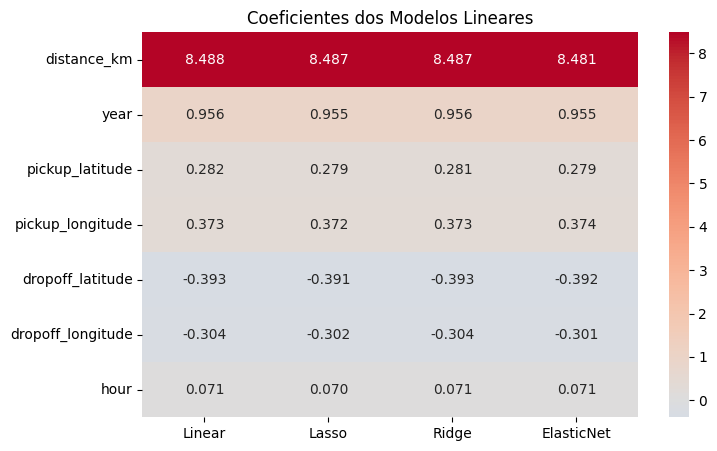

In [ ]:
import pandas as pd
import seaborn as sns

lingreg1: LinearRegression  = LR1[1]
lasso1:   Lasso             = Lasso1.best_estimator_[1]
ridge1:   Ridge             = Ridge1.best_estimator_[1]
enet:     ElasticNet        = EN1.best_estimator_[1]

df_coef = pd.DataFrame({
    'Linear': lingreg1.coef_,
    'Lasso': lasso1.coef_,
    'Ridge': ridge1.coef_,
    'ElasticNet': enet.coef_
}, index=X_train.columns)

plt.figure(figsize=(8,5))
sns.heatmap(df_coef, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Coeficientes dos Modelos Lineares')
plt.show()


Podemos observar que todos os modelos lineares (treinados nas features
originais) chegaram a aproximadamente aos mesmos valores para os
coeficientes para os preditores utilizados. Isso significa que os coeficientes
possuem valores estáveis e não exigem forte regularização, o que pode
ser percebido também pelos valores do coeficientes achados por validação
cruzada: 0.001 para o Lasso e o ElasticSearch. O Ridge precisou de regularização
mais forte, provavelmente por usar norma L2 sobre o vetor dos coeficientes.

Como esperado, a distância e o ano obtiveram os maiores coeficientes,
principalmente porque sao preditores relacionados linearmente com
o preço. As features geográficas, por não possuirem relação linear
com a variável alvo, tiveram coeficientes mais baixos.

Algumas interpretações que podem ser feitas são

- A cada quilômetro percorrido, o preço aumenta em cerca de 8.5 dólares

- A cada ano, ocorre um aumento de um dólar no preço da corrida.

Podemos perceber que a hora teve bem menos, provavelmente por ter
uma correlação fraca com a variável alvo, e a informação explicada
por ela sobre o preço não ser linear.

Dessa forma, se optássemos por usar um modelo linear para realizar a predição,
a Regressão Linear, sendo o modelo mais simples, já seria suficiente.

## KNN

o KNN, por ser um método não paramétrico,
obteve um erro menor do que os lineares,
provavelmente por capturar melhor a não linearidade
nas outras features.
Sua validação cruzada levou um tempo maior, mas
isso se deve por ela ter sido realizada numa grade
maior de parâmetros. O tempo de treinamento em si
é praticamente instantâneo, porém tendo o maior tempo
para realizar predições.

Quanto aos hiperparâmetros, encontrou-se k=9, p=2 e uso da média ponderada
para realizar a predição. Dada a dimensão do dataset, o valor de k sugere
que realmente corridas bem proximas no espaço das variáveis sejam consideradas,
enquanto que o uso da norma euclidiana pode sugerir que o modelo entendeu, em especial, que
corridas que ocorrem em localizações ficamente próximas tem preços parecidos.

## Árvore de Regressão

As árvores de Regressão conseguiram balancear bem performance
e erro de predição, sendo esse um pouco maior do que
aquele motrado pelo KNN.

AS árvores nos permitem dizer a importância de algumas features,
que são mostradas abaixo.

Text(0.5, 1.0, 'Importância das features para Árvore de Regressão')

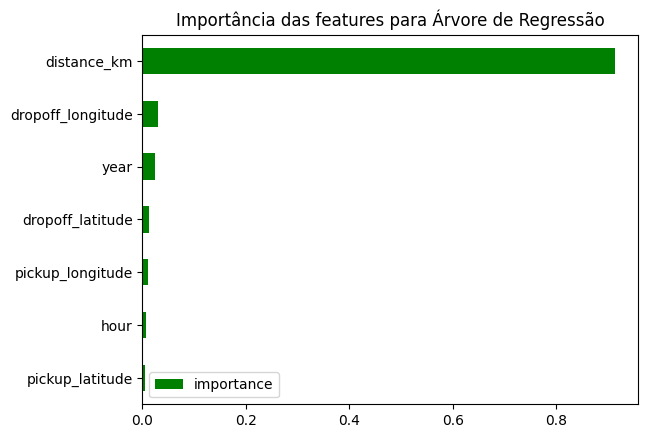

In [ ]:
importances = pd.DataFrame(
    DTR1.best_estimator_[1].feature_importances_,
    index=RF1.best_estimator_.feature_names_in_,
    columns=['importance']
)
importances.sort_values(by='importance', ascending=True, inplace=True)
importances.plot.barh(color='green')
plt.title("Importância das features para Árvore de Regressão")

Vemos que mais uma vez a distância é a variável mais explicativa para
o preço da corrida, capturando mais de 90% da importância do modelo.
As demais features possuem importâncias quase desprezíveis, o que significa
que, apesar de ser um modelo não paramétrico assim como o KNN, as árvores
talvez não tenham capturado tanto quanto aquele a não linearidade
dessas features.

No seu treinamento, as árvores decidem a covariável e o ponto de corte
que irá pariticionar os espaço das covariáveis. Como a distância é de longe a mais
explicativa e correlacionada com o alvo, seu uso para realizar a partição leva
a reduções maiores no RSS, aumentando sua importância.

## Bagging

O Bagging treinado nas features originais
feito com 100 árvores de decisão obteve o segundo menor MSE
entre os modelos, mas também é o modelo com menor performance em
tempo de treino. Tanto ele, quanto sua contraparte com PCA foram
os únicos a ultrapassar 1 minuto de treino, sendo que o primeiro
precisou de mais de 3 minutos para realizar o fit. Isso deve-se
provavelmente ao número de estimadores usados.

## Florestas Aleatórias

A floresta aleatória treinada nas features originais foi a que obteve o
menor MSE dentre todos os modelos, fazendo deste o modelo que melhor
capturou as informações nos dados até então. Quantos aos parâmetros,
o menor $\alpha$ disponível para validação, com valor de 0.0001, foi escolhido,
sugerindo que talvez um fator de penalização mais baixo fosse necessário, e as
árvores conseguiriam um MSE de teste menor se fossm maiores. Vale destacar
também que a Floresta Aleatória com 50 estimadores obteve resultados melhores
do que o Bagging com 100 estimadores, o que talvez deve ocorrer
pelo modelo de Floresta tentar criar estimadores não correlacionados,
de forma que o Bagging, na forma como o treinamos, tenha estimadores redundantes

Abaixo está as importâncias de cada feature usada.

Text(0.5, 1.0, 'Importância das features para Floresta Aleatória')

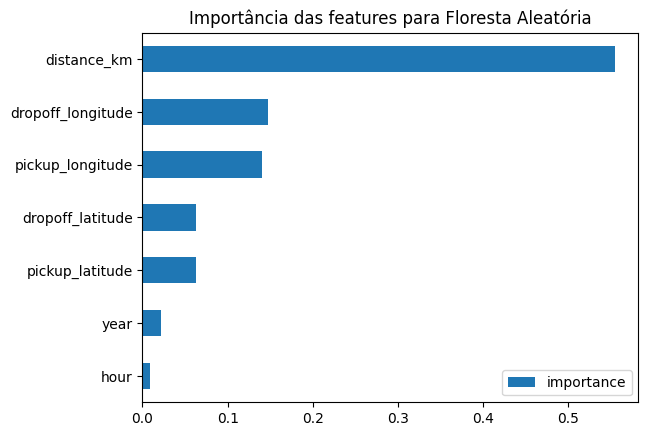

In [ ]:
importances = pd.DataFrame(
    RF1.best_estimator_[1].feature_importances_,
    index=RF1.best_estimator_.feature_names_in_,
    columns=['importance']
)
importances.sort_values(by='importance', ascending=True, inplace=True)
importances.plot.barh()
plt.title("Importância das features para Floresta Aleatória")

A importância medida pela floresta aleatória contrasta com aquela
que vimos para os modelos lineares e a Árvore de Regressão solo.
Aqui, além da já esperada distância, as features geográficas passaram
ter importância maior, ou seja, o modelo conseguiu capturar melhor a variação
dos preços em relação aos aspectos geográficos como havíamos hipotetizado
na análise exploratória. Uma hipótese para o aumento da importância das features
geográficas é que na construção dos estimadores da Floresta Aleatória, somente
um subconjunto das features é usado, permitindo que essas features tenham mais
oportunidade de ter sua informação utlizada para modelar os dados.

Diferente dos modelos lineares, esse modelo não deu muita importância para o
ano da corrida.

# Conclusões

Utilizamos um conjunto pequeno de features para treinar modelos em uma base de dados
que, mesmo após um pré-processamento extenso, ainda continha cerca de 190 mil amostras,
ou seja, esperávamos que modelos não paramétricos tivessem melhores resultados de predição
por possuirem melhor capacidade de se ajustar aos dados de treino com risco menor de overfitting
devido a ordem de grandeza dos dados.

A análise exploratória revelou que apenas duas features tinham uma relação linear
com o preço da corrida, sendo elas a distância percorrida e o ano, o que faz sentido,
pois corridas mais longas tendem a ser mais caras por custos e tempo, e ao longo dos
anos o preço pode sofrer efeitos inflacionários. As demais features tiveram correlações
pequenas e relação não linear com a média do preço, o que dificultou um pouco a extração de informação delas.
Em especial, as features geográficas foram mais difíceis de explorar, pois necessitaríamos de outras técnicas
para conseguir extrair informações de "zonas" em que as corridas seriam mais caras ou baratas.

Quantos aos modelos, fizemos uma rápida análise de suas performances, comportamento dos estimadores e a
influência do uso do PCA nos resultados do treinamento. Todos os modelos
conseguiram bons resultados para o MSE, tendo, considerando todos os estimadores, um erro
médio de cerca de 1 dólar e 40 centavos no preço. Dentre os modelos que conseguiram equilibrar
relativamente bem a performance e o erro, destaca-se aqui o KNN e a Floresta Aleatória, que obtiveram
um $\sqrt{\text{MSE}}$ de 1.30 e 1.28 respectivamente. O primeiro é mais simples e possui um tempo de
treinamento menor, enquanto que o segundo possui um erro menor e possui um tempo de predição consideralvelmente
menor (0.3 segundos para floresta contra 3 segundos do KNN). Apesar do tempo de treinamento da Floresta Aleatória
ser maior do que do KNN, ele ainda não ultrapassa 1 minuto. Portanto, indica-se a Floresta Aleatória como melhor
preditor para preço visto a amostra utilizada.

